In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, linear_model, neighbors, neural_network
from sklearn.metrics import ConfusionMatrixDisplay

from skimage.feature import hog
from skimage import exposure
import joblib

np.random.seed(42)

from torch.utils.data.dataset import Dataset
from torchvision import transforms
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda:0


In [4]:
#from tqdm.notebook import tqdm
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
        acc = (output.argmax(dim=1) == target).sum()/ len(target)
        loss_log.append(loss.item())
        acc_log.append(acc.item())   
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    kol = 0
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).sum()/ len(target)
        loss_log.append(loss.item())
        acc_log.append(acc.item())
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [69]:
class CustomDatasetFromImages2(Dataset):
    def __init__(self, csv_path):
        self.aug_flip = transforms.RandomHorizontalFlip()
        #self.aug_pers = transforms.RandomPerspective(distortion_scale = 0.3)
        self.to_norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.to_tensor = transforms.ToTensor()
        self.data_info = pd.read_csv(csv_path, header=None)
        self.data_info = self.data_info[self.data_info.iloc[:, 1] != 'unknown']
        #print(self.data_info.iloc[0, :])
        self.data_info.drop(labels = [0], axis = 0, inplace = True) 
        #print(self.data_info.iloc[0, :])
        self.data_info.replace({'bumper_dent': 1, 'bumper_scratch': 2, 'door_dent':3, 'door_scratch':4,
                 'glass_shatter':5, 'head_lamp':6, 'tail_lamp':0}, inplace = True)
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        self.data_len = len(self.data_info.index)
        #print(self.data_len)
        #print(len(self.image_arr))

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        s_img = '/kaggle/input/hse-car-damage-detection/' + single_image_name
        img_as_img = Image.open(s_img)
        img_as_img = self.aug_flip(img_as_img)
        #img_as_img = self.aug_pers(img_as_img)
        img_as_tensor = self.to_tensor(img_as_img)
        img_as_tensor_normed = self.to_norm(img_as_tensor)
        single_image_label = self.label_arr[index]
        return (img_as_tensor_normed, single_image_label)

    def __len__(self):
        return self.data_len
  
custom_ds2 =  CustomDatasetFromImages2('/kaggle/input/hse-car-damage-detection/all_data.csv')

train_idx, valid_idx = train_test_split(np.arange(len(custom_ds2)), test_size=0.3, shuffle=True, random_state=42)
trainset = torch.utils.data.Subset(custom_ds2, train_idx)
valset = torch.utils.data.Subset(custom_ds2, valid_idx)
#mn_dataset_loader = torch.utils.data.DataLoader(dataset = custom_ds, batch_size=64, shuffle=False)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, batch_size = 32, shuffle = False, num_workers = 2)

In [64]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    #clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('batch')
        ax.legend()

    plt.show()

In [70]:
class BasicBlockNet4(nn.Module): #best
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1), 
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1), 
            nn.BatchNorm2d(num_features = 64)
        )
        self.con11 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels = 64, kernel_size=1))
        self.finrelu = nn.Sequential(nn.ReLU())
        self.pool_out = nn.Sequential(nn.AvgPool2d(64))
        self.classifier = nn.Linear(in_features = 576, out_features = 7)
        
    def forward(self, x):
        con = self.con11(x)
        feat_map = self.net(x)
        out = self.finrelu(con + feat_map)
        out = self.pool_out(out)
        out = torch.flatten(out, start_dim = 1, end_dim = 3)
        out = self.classifier(out)

        return out

Epoch 0
 train loss: 1.8122344793275345, train acc: 0.29222766188688054
 val loss: 1.7913630322406167, val acc: 0.2870979532599449

Epoch 1
 train loss: 1.5866233942120573, train acc: 0.4199051406494407
 val loss: 1.647894445218538, val acc: 0.3545321637862607

Epoch 2
 train loss: 1.4404991920604262, train acc: 0.4534118729968404
 val loss: 2.1766470419733146, val acc: 0.3389985380988372

Epoch 3
 train loss: 1.4139382423356521, train acc: 0.4632802938306054
 val loss: 1.4886803438788967, val acc: 0.42872807069828633

Epoch 4
 train loss: 1.3198644518852234, train acc: 0.5003824968670689
 val loss: 1.4378570757414166, val acc: 0.47076023409241124

Epoch 5
 train loss: 1.2701689795006152, train acc: 0.525053549644559
 val loss: 1.4253730271991931, val acc: 0.4632675443824969

Epoch 6
 train loss: 1.2501960632412932, train acc: 0.5371787028257237
 val loss: 1.4824798797306262, val acc: 0.45175438648776006

Epoch 7
 train loss: 1.2505458745845528, train acc: 0.528266524159631
 val loss: 

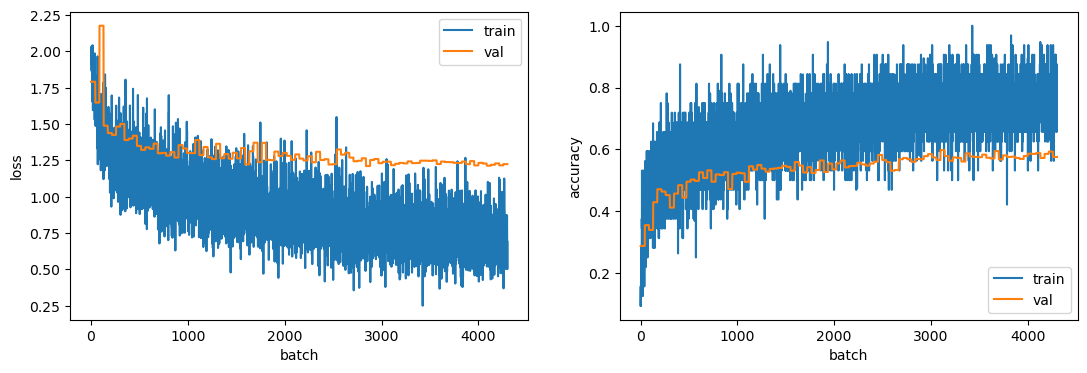

In [73]:
net_multi3 = BasicBlockNet4().to(device)
optimizer = optim.SGD(net_multi3.parameters(), lr = 0.01, momentum = 0.9)
#optimizer = optim.Adam(net_multi3.parameters(), lr=0.1)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 100)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, total_steps = 100)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log3, tr_acc_log3, val_loss_log3, val_acc_log3 = train(net_multi3, optimizer, 100, train_loader, val_loader, scheduler)

val_loss_n3 = []*len(tr_loss_log3)
val_acc_n3 = []*len(tr_acc_log3)
for i in range(len(val_loss_log3)):
    kol = 0
    while kol < len(tr_loss_log3) / len(val_loss_log3):
        val_loss_n3.append(val_loss_log3[i])
        val_acc_n3.append(val_acc_log3[i])
        kol += 1
    #print(val_loss_new)
plot_losses(tr_loss_log3,val_loss_n3, tr_acc_log3, val_acc_n3)

In [74]:
from sklearn.metrics import classification_report

def test_f1_scores(model, loader):
    answ = []
    pred = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(data)
        for i in range(len(target)):
            pr = output[i].cpu().argmax()
            an = target[i].cpu()
            dict_ans = {'bumper_dent': 1, 'bumper_scratch': 2, 'door_dent':3, 'door_scratch':4,
                 'glass_shatter':5, 'head_lamp':6, 'tail_lamp':0}
            for k in dict_ans.keys():
                if dict_ans[k] == pr:
                    pred.append(k)
                if dict_ans[k] == an:
                    answ.append(k)
    print(classification_report(answ, pred))
    return 

In [75]:
test_f1_scores(net_multi3, val_loader)

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        63
           1       0.49      0.39      0.43        67
           2       0.55      0.56      0.55        88
           3       0.49      0.55      0.52       110
           4       0.42      0.43      0.43        86
           5       0.84      0.84      0.84        91
           6       0.66      0.74      0.70        80

    accuracy                           0.58       585
   macro avg       0.59      0.58      0.58       585
weighted avg       0.59      0.58      0.58       585



0.628269612789154 bumper_dent


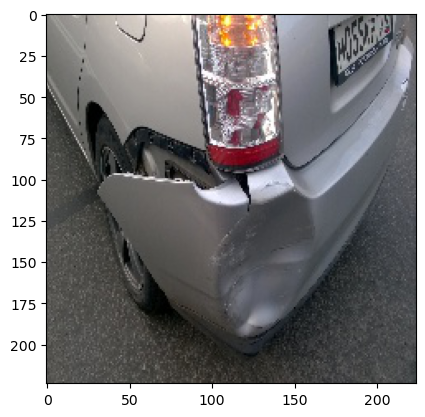

In [83]:
def transform_single_image(s_img):
        img_as_img = Image.open(s_img)
        plt.imshow(img_as_img)
        my_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                         
        img_as_tensor = my_transform(img_as_img)
        return img_as_tensor.unsqueeze(0)
    
def pred_single_image(name, model):
        tens = transform_single_image(name)
        tens = tens.to(device)
        rez = model.forward(tens)
        probs = torch.nn.functional.softmax(rez, dim=1)
        conf, pred = torch.max(probs, 1)
        dict_ans = {'bumper_dent': 1, 'bumper_scratch': 2, 'door_dent':3, 'door_scratch':4,
                 'glass_shatter':5, 'head_lamp':6, 'tail_lamp':0}
        for k in dict_ans.keys():
            if dict_ans[k] == pred:
                ans = k
        return conf.item(), ans
    
confidence, prediction = pred_single_image('/kaggle/input/hse-car-damage-detection/all_images/27.jpg', net_multi3)
print(confidence, prediction)

In [84]:
model_scripted = torch.jit.script(net_multi3) # Export to TorchScript
model_scripted.save('model_scripted.pt')